In [2]:
import pylab
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
data_df = pd.read_csv('./data.csv')
data_df['game_date'] = data_df['game_date'].apply(lambda x: pd.to_datetime(x))
print(data_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
action_type           30697 non-null object
combined_shot_type    30697 non-null object
game_event_id         30697 non-null int64
game_id               30697 non-null int64
lat                   30697 non-null float64
loc_x                 30697 non-null int64
loc_y                 30697 non-null int64
lon                   30697 non-null float64
minutes_remaining     30697 non-null int64
period                30697 non-null int64
playoffs              30697 non-null int64
season                30697 non-null object
seconds_remaining     30697 non-null int64
shot_distance         30697 non-null int64
shot_made_flag        25697 non-null float64
shot_type             30697 non-null object
shot_zone_area        30697 non-null object
shot_zone_basic       30697 non-null object
shot_zone_range       30697 non-null object
team_id               30697 non-null int64
team_name         

In [3]:
import math
data_df['angle'] = np.degrees(np.arctan(data_df['loc_y']/data_df['loc_x']))
data_df['angle'] = data_df['angle'].apply(lambda x: 180-x if x>0 else -x)
data_df['angle'] = data_df['angle'].apply(lambda x: 90 if math.isnan(x) else x)

C:\Users\shail\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in arctan
  


In [4]:
# Remove unnecessary columns
#data_df = data_df.drop(columns=['combined_shot_type', 'game_event_id', 'game_id', 'lat', 'lon', 'shot_type', 'shot_zone_range', 'team_id', 'team_name'])
preprocess_df = data_df[['action_type', 'angle', 'period', 'playoffs', 'shot_distance', 'shot_made_flag', 'shot_zone_area', 'shot_zone_basic', 'opponent']]

In [5]:
# from https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

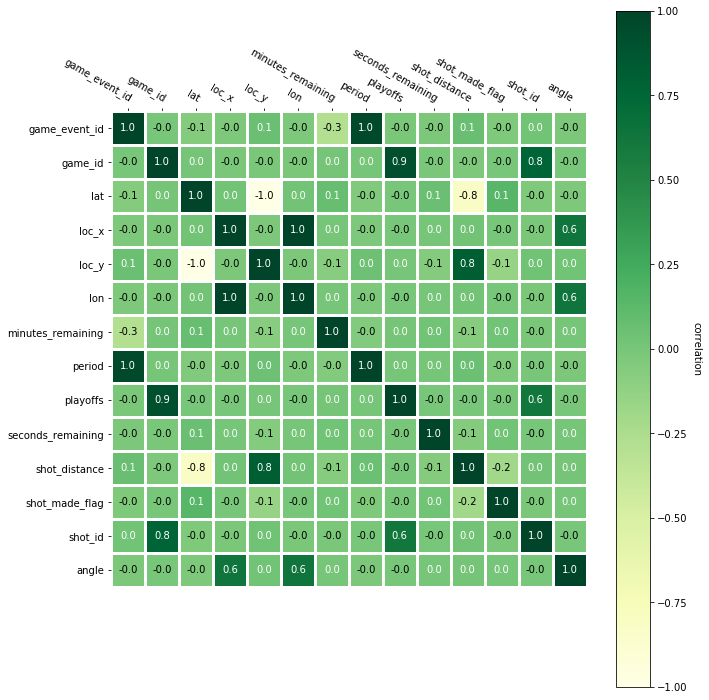

In [29]:
fig, ax = plt.subplots(figsize=(10,10))

corr_df = data_df.drop(columns=['team_id']).dropna().corr()
im, cbar = heatmap(corr_df, corr_df.columns, corr_df.columns, ax=ax,
                   cmap="YlGn", cbarlabel="correlation")
texts = annotate_heatmap(im, valfmt="{x:.1f}")

fig.tight_layout()
plt.show()

In [6]:
# Feature preprocessing
preprocess_df['season'] = data_df['season'].apply(lambda x: int(x[0:4])-1996)

preprocess_df['matchup'] = data_df['matchup'].apply(lambda x: 0 if "@" in x else 1)

preprocess_df['time_remaining'] = (data_df['minutes_remaining']*60) + data_df['seconds_remaining']

min_dates = pd.DataFrame(data_df, columns=['game_date'])
min_date = min_dates.min()
preprocess_df['game_date'] = data_df['game_date'].apply(lambda x: (x - min_date).dt.days)

C:\Users\shail\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\shail\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\shail\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org

# Visualization

In [8]:
def bar_chart(names, points, xlabel, ylabel, title, label_rects=True, xticks_rotation='horizontal'):
    # data to plot
    n_groups = len(points)

    # create plot
    fig, ax = plt.subplots(figsize=(10, 10))
    index = np.arange(n_groups)
    bar_width = 0.5
    opacity = 0.8

    rects = plt.bar(index, points, bar_width,
    alpha=opacity,
    color='b')

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{0:.3f}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    if label_rects:
        autolabel(rects)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(index, (names), rotation=xticks_rotation)
    ax.set_ylim([0,1])
    #plt.legend()

    plt.tight_layout()
    plt.show()

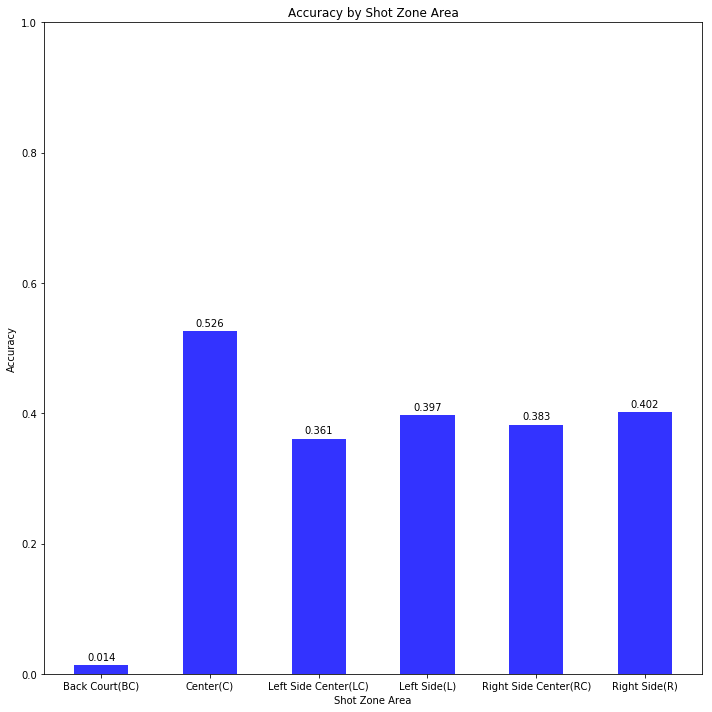

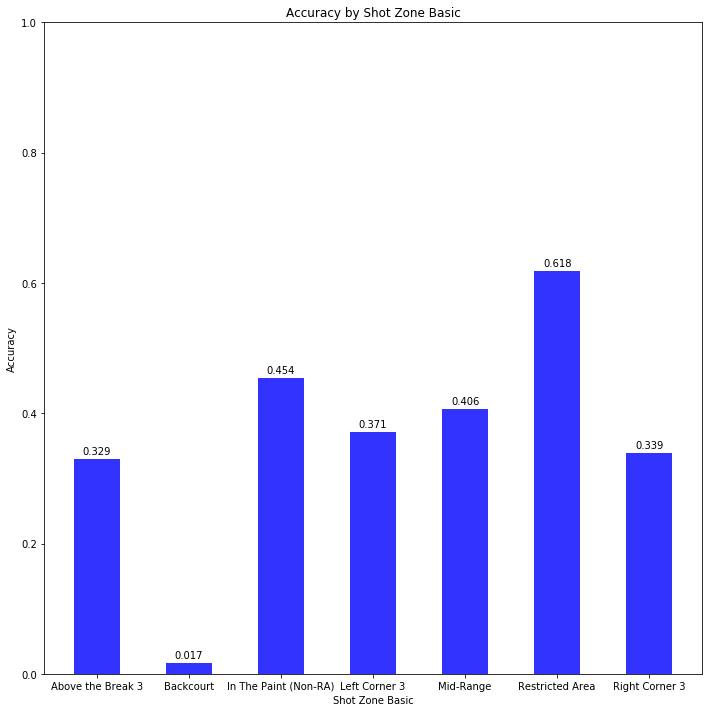

In [9]:
group = preprocess_df.dropna().groupby('shot_zone_area')['shot_made_flag'].mean()
bar_chart(group.index, group.values, "Shot Zone Area", "Accuracy", "Accuracy by Shot Zone Area", label_rects=True, xticks_rotation='horizontal')
group = preprocess_df.dropna().groupby('shot_zone_basic')['shot_made_flag'].mean()
bar_chart(group.index, group.values, "Shot Zone Basic", "Accuracy", "Accuracy by Shot Zone Basic", label_rects=True, xticks_rotation='horizontal')

In [10]:
def scatter_plot(df, title, column, loc_x='loc_x', loc_y='loc_y'):
    # create plot
    fig, ax = plt.subplots(figsize=(10, 10))
    alpha=0.25
    
    for i, val in enumerate(df[column].unique()):
        part = df[df[column] == val]
        plt.scatter(part[loc_x], part[loc_y], alpha=alpha)
    
    plt.axis('scaled')
    plt.title(title)
    plt.legend(df[column].unique())
    plt.show()

KeyError: 'loc_x'

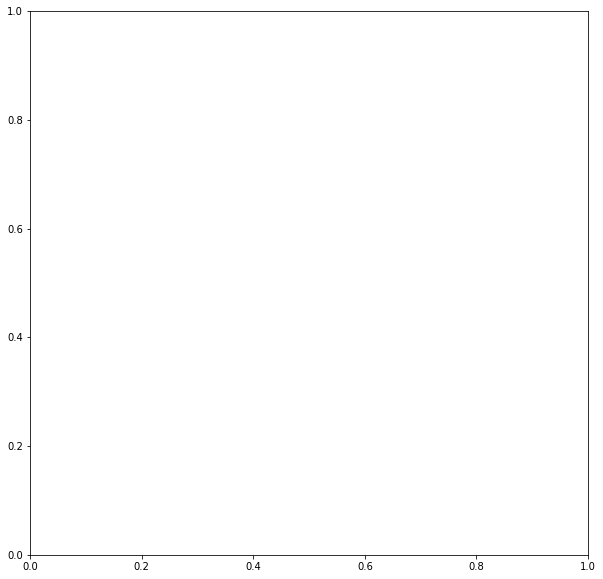

In [11]:
scatter_plot(preprocess_df, "Shot Zone Area", 'shot_zone_area')
scatter_plot(preprocess_df, "Shot Zone Area", 'shot_zone_basic')

In [12]:
def line_graph(names, points, xlabel, ylabel, title, label_points=True, xtick_step=None):
    # create plot
    fig, ax = plt.subplots(figsize=(10, 10))
    
    plt.plot(names, points, linestyle='-', marker='o', color='b')
    
    if label_points:
        for name, point in zip(names, points):
            plt.annotate('{0:.2f}'.format(point), # this is the text
                         (name, point), # this is the point to label
                         textcoords="offset points", # how to position the text
                         xytext=(0,10), # distance from text to points (x,y)
                         ha='center') # horizontal alignment can be left, right or center
    
    plt.title(title)
    if xtick_step == None:
        plt.xticks(names)
    else:
        plt.xticks(np.arange(min(names), max(names), step=xtick_step))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.ylim(0, 1)
    plt.show()

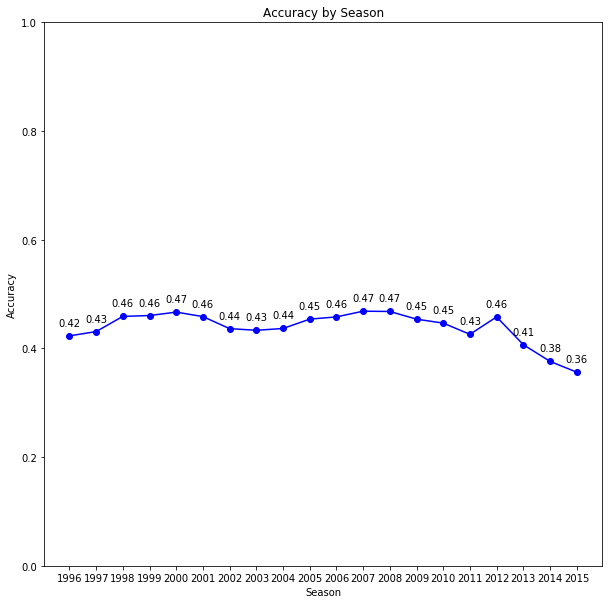

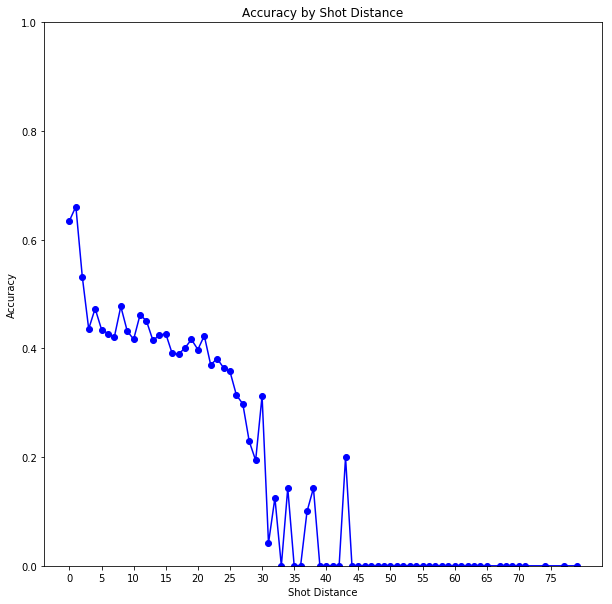

In [13]:
group = preprocess_df.dropna().groupby('season')['shot_made_flag'].mean()
line_graph([x+1996 for x in group.index], group.values, "Season", "Accuracy", "Accuracy by Season")
group = preprocess_df.dropna().groupby('shot_distance')['shot_made_flag'].mean()
line_graph(group.index, group.values, "Shot Distance", "Accuracy", "Accuracy by Shot Distance", label_points=False, xtick_step=5)

# Finish Encoding and Standardizing Data for Testing

In [14]:
categorical_columns = ['action_type', 'combined_shot_type', 'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range', 'team_name', 'opponent']
numeric_columns = ['lat', 'angle', 'lon', 'minutes_reamining', 'seconds_remaining', 'shot_distance', 'time_remaining', 'period', 'season']

In [15]:
# Uncomment for onehot encoding
preprocess_df = pd.get_dummies(preprocess_df, prefix_sep=':', columns=['action_type', 'shot_zone_area', 'shot_zone_basic', 'opponent'])

In [7]:
# Uncomment for ordinal encoding
# allFeatures = {}

# for feature in preprocess_df:
#     if feature in categorical_columns:
#         uniques = preprocess_df[feature].unique()
#         categories_to_index = {}

#         for counter in range(len(uniques)):
#             categories_to_index[uniques[counter]] = counter

#         allFeatures[feature] = categories_to_index

# preprocess_df.replace(allFeatures, inplace=True)

/usr/local/lib/python2.7/dist-packages/pandas/core/generic.py:3855: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)


In [16]:
# Standardize the features
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
standardize_columns = numeric_columns + categorical_columns
#standardize_cols = numeric_columns
def standardize(df):
    for column in df:
        if column in standardize_columns:
            # data_df[column] = StandardScaler().fit_transform(data_df[column].values.reshape(-1,1))
            df[column] = MinMaxScaler().fit_transform(df[column].values.reshape(-1,1))
            
standardize(preprocess_df)

C:\Users\shail\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\shail\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\shail\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\shail\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [40]:
preprocess_df

,angle,period,playoffs,shot_distance,shot_made_flag,season,matchup,time_remaining,game_date,action_type:Alley Oop Dunk Shot,...,opponent:PHI,opponent:PHX,opponent:POR,opponent:SAC,opponent:SAS,opponent:SEA,opponent:TOR,opponent:UTA,opponent:VAN,opponent:WAS
0,0.871562,0.000000,0,0.227848,NaN,0.210526,0,0.878151,1458,0,...,0,0,1,0,0,0,0,0,0,0
1,0.000000,0.000000,0,0.189873,0.0,0.210526,0,0.871148,1458,0,...,0,0,1,0,0,0,0,0,0,0
2,0.295929,0.000000,0,0.202532,1.0,0.210526,0,0.651261,1458,0,...,0,0,1,0,0,0,0,0,0,0
3,0.713473,0.000000,0,0.278481,0.0,0.210526,0,0.577031,1458,0,...,0,0,1,0,0,0,0,0,0,0
4,0.500650,0.166667,0,0.000000,1.0,0.210526,0,0.530812,1458,0,...,0,0,1,0,0,0,0,0,0,0
5,0.977168,0.333333,0,0.177215,0.0,0.210526,0,0.801120,1458,0,...,0,0,1,0,0,0,0,0,0,0
6,0.500650,0.333333,0,0.000000,1.0,0.210526,0,0.745098,1458,0,...,0,0,1,0,0,0,0,0,0,0
7,0.512029,0.333333,0,0.025316,NaN,0.210526,0,0.679272,1458,0,...,0,0,1,0,0,0,0,0,0,0
8,0.327972,0.333333,0,0.151899,1.0,0.210526,0,0.521008,1458,0,...,0,0,1,0,0,0,0,0,0,0
9,0.418384,0.333333,0,0.151899,0.0,0.210526,0,0.302521,1458,0,...,0,0,1,0,0,0,0,0,0,0


# Train / Test Splitting

In [17]:
full_df = preprocess_df[preprocess_df.apply(lambda x: not pd.isnull(x.shot_made_flag), axis=1)]
kaggle_df = preprocess_df[preprocess_df.apply(lambda x: pd.isnull(x.shot_made_flag), axis=1)]

In [18]:
from sklearn.model_selection import train_test_split

feats = full_df.drop('shot_made_flag', axis=1)
labels = full_df['shot_made_flag']

feats_train, feats_test, labels_train, labels_test = train_test_split(feats, labels, random_state=1, test_size=0.2)

In [21]:
names = []
accuracies = []
log_losses = []

# Decision Tree

In [44]:
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss
model = tree.DecisionTreeClassifier(max_depth=6, splitter="best")
model.fit(feats_train, labels_train)
predictions_test = model.predict(feats_test)
probabilities_test = model.predict_proba(feats_test)

acc = accuracy_score(labels_test, predictions_test)
ll = log_loss(labels_test, probabilities_test)
names.append("Decision Tree")
accuracies.append(acc)
log_losses.append(ll)
print("Accuracy: " + str(acc))
print("Log Loss: " + str(ll))

Accuracy: 0.6752918287937744
Log Loss: 0.6869051316556997


# Random Forest

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, StratifiedKFold

# param_grid = [{'n_estimators': [100, 200, 500],
#                'max_depth': [None, 5, 8, 10, 12, 14, 16]
#                }]
param_grid = [{'n_estimators': [100]}]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12345)
clf = GridSearchCV(RandomForestClassifier(criterion='gini', random_state=12345), param_grid, cv=cv,
                       scoring=['neg_log_loss', 'accuracy'], refit='neg_log_loss')
clf.fit(feats_train, labels_train)
print(clf.best_params_)
results = clf.cv_results_
predictions_test = clf.predict(feats_test)
probabilities_test = clf.predict_proba(feats_test)

acc = accuracy_score(labels_test, predictions_test)
ll = log_loss(labels_test, probabilities_test)
names.append("Random Forest")
accuracies.append(acc)
log_losses.append(ll)
print("Accuracy: " + str(acc))
print("Log Loss: " + str(ll))

{'n_estimators': 100}
Accuracy: 0.6573929961089494
Log Loss: 0.6335771276874619


# Naive Bayes

In [22]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(feats_train, labels_train)
predictions_test = nb.predict(feats_test)
probabilities_test = nb.predict_proba(feats_test)

acc = accuracy_score(labels_test, predictions_test)
ll = log_loss(labels_test, probabilities_test)
names.append("Naive Bayes")
accuracies.append(acc)
log_losses.append(ll)
print("Accuracy: " + str(acc))
print("Log Loss: " + str(ll))

NameError: name 'accuracy_score' is not defined

# Multilayer Perceptron

In [47]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score

# hidden_layers= [15, 15, 15, 15, 15, 15, 15, 15]
# accuracies = []

# for i in range(len(hidden_layers)):
#     clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=hidden_layers[0:i], learning_rate="adaptive", activation="relu")
#     clf.fit(feats_train, labels_train)
#     predictions_test = clf.predict(feats_test)
#     accuracies.append(accuracy_score(labels_test, predictions_test, normalize=False)/len(labels_test))

#param_grid = [{'hidden_layer_sizes': [[15], [15, 15], [15, 15, 15], [15, 15, 15, 15], [15, 15, 15, 15, 15], [15, 15, 15, 15, 15, 15], [15, 15, 15, 15, 15, 15, 15], [15, 15, 15, 15, 15, 15, 15, 15]]}]
param_grid = [{'hidden_layer_sizes': [[15], [15, 15]]}]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12345)
clf = GridSearchCV(MLPClassifier(solver='adam', alpha=1e-5, learning_rate="adaptive", activation="relu", random_state=12345), param_grid, cv=cv,
                       scoring=['neg_log_loss', 'accuracy'], refit='neg_log_loss')
clf.fit(feats_train, labels_train)
print(clf.best_params_)
results = clf.cv_results_
predictions_test = clf.predict(feats_test)
probabilities_test = clf.predict_proba(feats_test)

# plt.plot(accuracies)
# plt.show()
acc = accuracy_score(labels_test, predictions_test)
ll = log_loss(labels_test, probabilities_test)
names.append("Neural Net")
accuracies.append(acc)
log_losses.append(ll)
print("Accuracy: " + str(acc))
print("Log Loss: " + str(ll))

{'hidden_layer_sizes': [15]}
Accuracy: 0.6821011673151751
Log Loss: 0.6169390446211497


# SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, log_loss
import time

start_time = time.time()
# param_grid = [{'kernel': ['rbf', 'sigmoid'], 'gamma': ['scale', 'auto', 0.1, 0.01, 0.001, 0.0001, 0.00001], 'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]}]
# best parameters
param_grid = [{'kernel': ['rbf'], 'gamma': [0.0001], 'C': [1000]}]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12345)
clf = GridSearchCV(SVC(probability=True, random_state=12345), param_grid, cv=cv, n_jobs=-1,
                   scoring=['accuracy'], refit='accuracy')
clf.fit(feats_train, labels_train)
print(clf.best_params_)
results = clf.cv_results_
predictions_test = clf.predict(feats_test)
probabilities_test = clf.predict_proba(feats_test)

end_time = time.time()
print("Time Elapsed: " + str(end_time-start_time))

acc = accuracy_score(labels_test, predictions_test)
prec = precision_score(labels_test, predictions_test)
rec = recall_score(labels_test, predictions_test)
ll = log_loss(labels_test, probabilities_test)
names.append("SVM")
accuracies.append(acc)
print("Accuracy: " + str(acc))
print("Precision: " + str(prec))
print("Recall: " + str(rec))
print("Log Loss: " + str(ll))

# Gradient Boosted Tree

In [24]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, log_loss

gb = GradientBoostingClassifier(n_estimators=100)
gb.fit(feats_train, labels_train)
predictions_test = gb.predict(feats_test)
probabilities_test = gb.predict_proba(feats_test)

acc = accuracy_score(labels_test, predictions_test)
ll = log_loss(labels_test, probabilities_test)
names.append("Gradient Boosted Tree")
accuracies.append(acc)
print("Accuracy: " + str(acc))

Accuracy: 0.6787937743190662


# Voting Ensemble

In [ ]:
from sklearn.ensemble import VotingClassifier

start_time = time.time()

# Uses Soft-Voting, not Hard/Majority Voting. Each classifier is given equal weight.
vc = VotingClassifier(estimators=[('dt', model), ('nb', nb), ('smv', clf)], voting='soft')
vc.fit(feats_train, labels_train)
predictions_test = vc.predict(feats_test)
probabilities_test = vc.predict_proba(feats_test)

end_time = time.time()
print("Time Elapsed: " + str(end_time-start_time))

acc = accuracy_score(labels_test, predictions_test)
prec = precision_score(labels_test, predictions_test)
rec = recall_score(labels_test, predictions_test)
ll = log_loss(labels_test, probabilities_test)
names.append("Soft Voting Ensemble")
accuracies.append(acc)
print("Accuracy: " + str(acc))
print("Precision: " + str(prec))
print("Recall: " + str(rec))
print("Log Loss: " + str(ll))

# Compare Classifiers

In [ ]:
print(names)
print(accuracies)

In [29]:
# accuracies_ordinal = accuracies

In [ ]:
accuracies_onehot = accuracies

In [ ]:
# data to plot
n_groups = 7

# create plot
fig, ax = plt.subplots(figsize=(10, 10))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, accuracies_ordinal, bar_width,
alpha=opacity,
color='b',
label='Ordinal Encoding')

rects2 = plt.bar(index + bar_width, accuracies_onehot, bar_width,
alpha=opacity,
color='g',
label='Onehot Encoding')

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{0:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Accuracies by Classifier')
plt.xticks(index + bar_width/2, (names))
ax.set_ylim([0,1])
plt.legend()

plt.tight_layout()
plt.show()

In [28]:
def show_roc_curve(fpr, tpr, roc_auc):
    import matplotlib
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,10))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.8f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

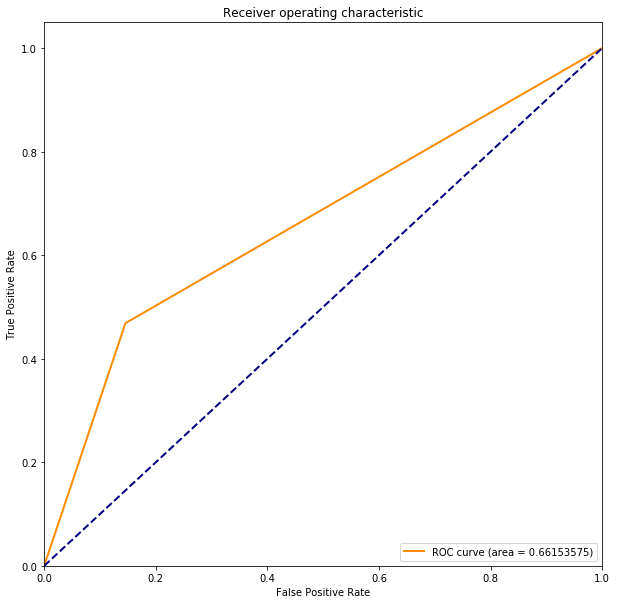

In [29]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, threshold = roc_curve(labels_test, predictions_test)
show_roc_curve(fpr, tpr, roc_auc_score(labels_test, predictions_test))